In [1]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("Quality_of_Life_final.csv")

categorical_cols = df.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col].astype(str))

# Define hyperparameter grid for RandomForestRegressor
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [1,0.5,0.3]
}

In [3]:
rf = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=30,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

X = df.dropna()
X_features = X.drop(columns=categorical_cols)

random_search.fit(X_features, X_features)
best_params = random_search.best_params_
print("Best Parameters:", best_params)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5, 'max_depth': 10}


In [5]:
rf_imputer = IterativeImputer(
    estimator=RandomForestRegressor(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        max_features=best_params['max_features'],
        random_state=42
    ),
    random_state=42
)

df_imputed_rf = pd.DataFrame(rf_imputer.fit_transform(df), columns=df.columns)

for col in categorical_cols:
    df_imputed_rf[col] = label_encoders[col].inverse_transform(df_imputed_rf[col].astype(int))


C:\Users\Tanay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [6]:
df_imputed_rf.to_csv("Imputed_Quality_of_Life.csv", index=False)

#### Imputer Evaluation

C:\Users\Tanay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


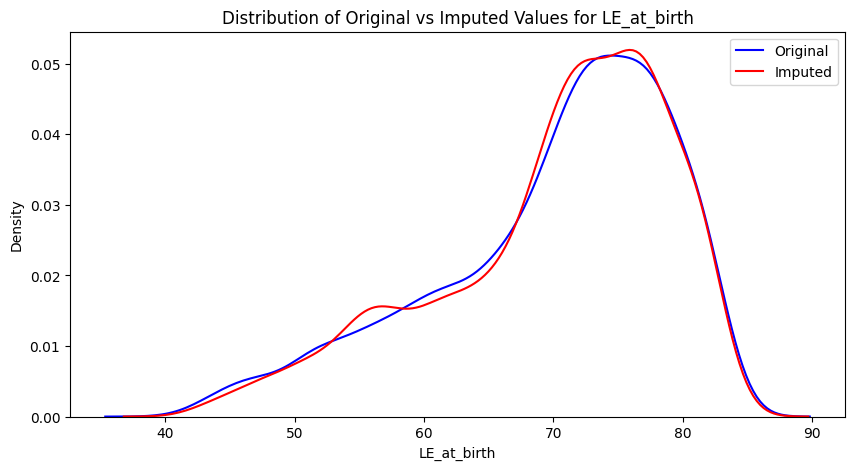

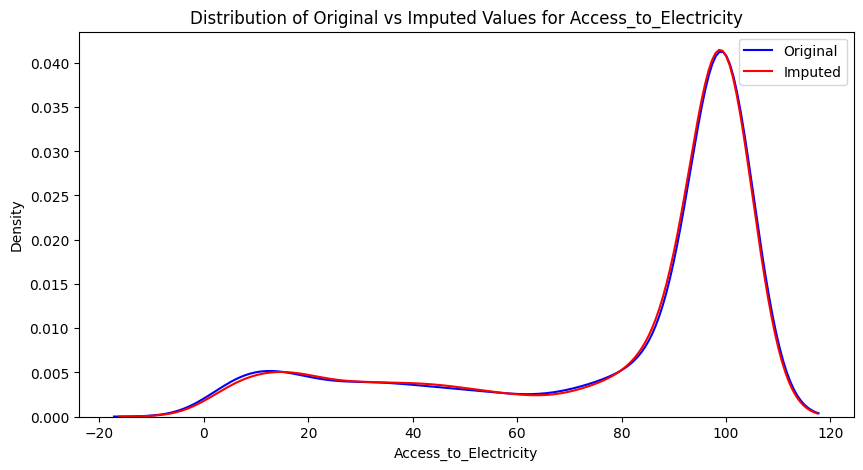

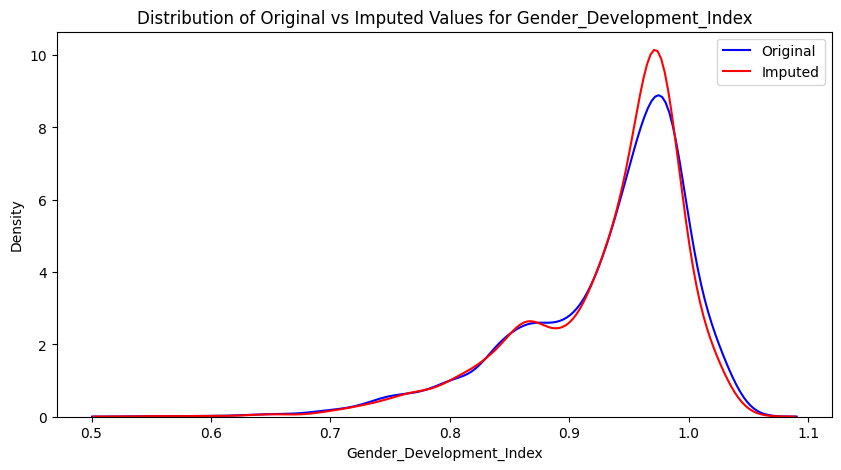

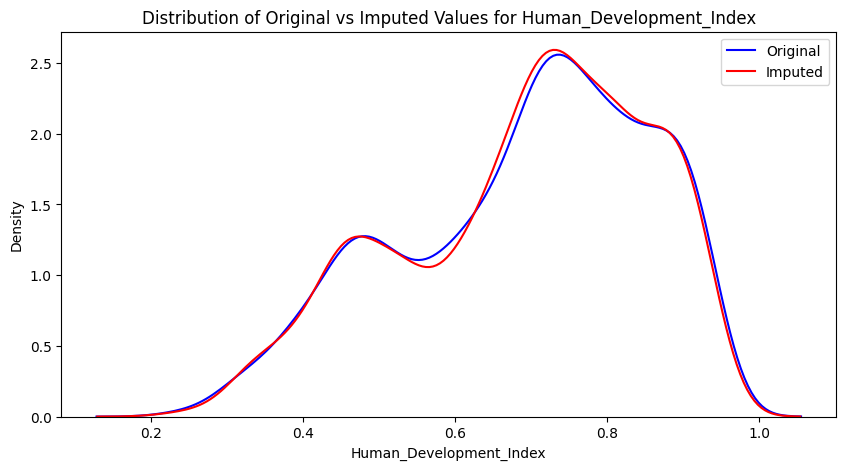

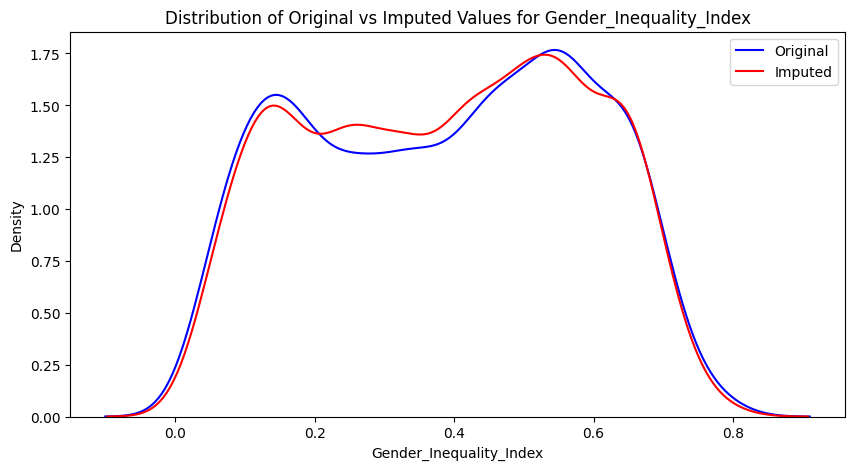

                     target       R^2      RMSE       MAE
0               LE_at_birth  0.952856  2.006853  0.766307
1     Access_to_Electricity  0.957913  6.383834  1.688838
2  Gender_Development_Index  0.916308  0.020550  0.008090
3   Human_Development_Index  0.971988  0.027417  0.010293
4   Gender_Inequality_Index  0.944280  0.046846  0.017396


In [11]:
synthetic_data = pd.read_csv('synthetic_data_healthcare.csv')
full_data = pd.read_csv('synthetic_data_healthcare_full.csv')

rf_imputer = IterativeImputer(
    estimator=RandomForestRegressor(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        max_features=best_params['max_features'],
        random_state=29
    ),
    random_state=29
)

synthetic_data_imputed = pd.DataFrame(rf_imputer.fit_transform(synthetic_data), columns=synthetic_data.columns)

# Initialize metrics storage
metrics = {'target': [], 'R^2': [], 'RMSE': [], 'MAE': []}

# Calculate R^2, RMSE, MAE for each column with missing values
missing_columns = synthetic_data.columns[synthetic_data.isnull().any()]

for column in missing_columns:
    y_true = full_data[column]
    y_pred = synthetic_data_imputed[column]

    # Calculate metrics
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    # Append metrics for this target
    metrics['target'].append(column)
    metrics['R^2'].append(r2)
    metrics['RMSE'].append(rmse)
    metrics['MAE'].append(mae)
    
    # Plot distribution comparison
    plt.figure(figsize=(10, 5))
    sns.kdeplot(y_true, label='Original', color='blue')
    sns.kdeplot(y_pred, label='Imputed', color='red')
    plt.title(f"Distribution of Original vs Imputed Values for {column}")
    plt.xlabel(column)
    plt.legend()
    plt.show()

# Display metrics as a DataFrame
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

In [5]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Load the full dataset
full_data = pd.read_csv('synthetic_data_healthcare_full.csv')

# Split the full data into 60-40 for training and testing
train_data, test_data = train_test_split(full_data, test_size=0.4, random_state=29)

# Create synthetic missing data in the test set by randomly setting values to NaN
np.random.seed(29)
missing_fraction = 0.3  # 70% of the data will be randomly masked as NaN
for column in test_data.columns:
    mask = np.random.rand(test_data.shape[0]) < missing_fraction
    test_data.loc[mask, column] = np.nan

# Initialize metrics storage
metrics = {'target': [], 'R^2': [], 'RMSE': [], 'MAE': []}

# Perform imputation and evaluation over 30 runs
for run in range(30):
    # Initialize Iterative Imputer with RandomForestRegressor using best parameters
    rf_imputer = IterativeImputer(
        estimator=RandomForestRegressor(
            n_estimators=best_params['n_estimators'],
            max_depth=best_params['max_depth'],
            min_samples_split=best_params['min_samples_split'],
            min_samples_leaf=best_params['min_samples_leaf'],
            max_features=best_params['max_features'],
            random_state=29 + run
        ),
        random_state=29 + run
    )

    # Perform imputation on the test data
    test_data_imputed = pd.DataFrame(rf_imputer.fit_transform(test_data), columns=test_data.columns)

    # Calculate metrics for each column with synthetic missing values
    missing_columns = test_data.columns[test_data.isnull().any()]

    for column in missing_columns:
        y_true = full_data.loc[test_data.index, column]  # Use the original full data as ground truth
        y_pred = test_data_imputed[column]

        # Calculate metrics
        r2 = r2_score(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)

        # Append metrics for this target
        metrics['target'].append(column)
        metrics['R^2'].append(r2)
        metrics['RMSE'].append(rmse)
        metrics['MAE'].append(mae)

# Display metrics as a DataFrame
metrics_df = pd.DataFrame(metrics)


metrics_summary = metrics_df.groupby('target').agg(
    R2_mean=('R^2', 'mean'),
    R2_std=('R^2', 'std'),
    RMSE_mean=('RMSE', 'mean'),
    RMSE_std=('RMSE', 'std'),
    MAE_mean=('MAE', 'mean'),
    MAE_std=('MAE', 'std')
).reset_index()

print(metrics_summary)

C:\Users\Tanay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\Tanay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\Tanay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\Tanay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [Itera

                     target   R2_mean    R2_std  RMSE_mean  RMSE_std  \
0     Access_to_Electricity  0.959260  0.001498   6.254061  0.114665   
1  Gender_Development_Index  0.908380  0.001968   0.021824  0.000234   
2   Gender_Inequality_Index  0.948183  0.001170   0.045520  0.000515   
3   Human_Development_Index  0.971285  0.000661   0.027767  0.000320   
4               LE_at_birth  0.948458  0.001252   2.120724  0.025769   

   MAE_mean   MAE_std  
0  1.844383  0.024776  
1  0.008360  0.000070  
2  0.016967  0.000215  
3  0.010579  0.000108  
4  0.846865  0.009192  


C:\Users\Tanay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
